In [4]:
import dash
import dash_bootstrap_components as dbc
import dash_pivottable
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import dash_table, dcc, html
from IPython.display import display
from jupyter_dash import JupyterDash
from plotly.subplots import make_subplots

pd.options.plotting.backend = "plotly"

COL_USERNAME = "username"
COL_GROUP = "group"
COL_TIMESTAMP = "timestamp"


def generate_test_data():
    num_users = 20
    num_groups = 3
    num_repeat = 10

    dates = pd.date_range(start="2022-01-01", end="2022-12-31")
    total_num = dates.shape[0] * num_repeat
    usernames = [
        f"user-{num}"
        for num in (np.random.rand(total_num) * num_users).astype(int).tolist()
    ]
    groups = [
        f"group-{num}"
        for num in (np.random.rand(total_num) * num_groups).astype(int).tolist()
    ]

    base_df = (
        pd.concat(
            [pd.DataFrame(dates, columns=[COL_TIMESTAMP]) for _ in range(num_repeat)]
        )
        .reset_index(drop=True)
        .assign(count=1)
    )
    df = base_df.assign(
        username=usernames,
        group=groups,
    )
    return df.drop_duplicates()


def convert_freq(df, freq):
    df[COL_TIMESTAMP] = df[COL_TIMESTAMP].dt.to_period(freq=freq).dt.start_time
    return df.drop_duplicates()


df = generate_test_data()
df = convert_freq(df, "W")
df.head()

,timestamp,count,username,group
0,2021-12-27,1,user-2,group-2
1,2021-12-27,1,user-19,group-0
2,2022-01-03,1,user-12,group-2
3,2022-01-03,1,user-11,group-2
4,2022-01-03,1,user-7,group-1


In [6]:
def create_matrix_username_index(df, add_column):
    return (
        df.reset_index()
        .pivot(
            index=[COL_USERNAME, add_column], columns=[COL_TIMESTAMP], values=["count"]
        )
        .droplevel(axis=1, level=0)
        .fillna(0)
    )


def create_matrix_timestamp_index(df, add_column):
    return (
        df.reset_index()
        .pivot(
            index=[COL_TIMESTAMP, add_column], columns=[COL_USERNAME], values=["count"]
        )
        .droplevel(axis=1, level=0)
        .fillna(0)
    )


def common_new_user(df, add_column):
    matrix_df = create_matrix_username_index(df, add_column)
    new_df = (
        matrix_df.idxmax(axis=1)
        .to_frame(name=COL_TIMESTAMP)
        .assign(count=1)
        .reset_index()
        .pivot(
            index=[COL_USERNAME, add_column], columns=[COL_TIMESTAMP], values="count"
        )
        .sort_index()
        .fillna(0)
    )
    return new_df


def get_new_user(df, add_column):
    return (
        common_new_user(df, add_column)
        .stack()
        .to_frame(name="count")
        .reset_index()
        .pivot(index=[COL_TIMESTAMP, add_column], columns=COL_USERNAME, values="count")
        .sum(axis=1)
    )


def get_new_user_mask(df, add_column):
    return common_new_user(df, add_column).cumsum(axis=1).astype(bool)


def get_retained_user(df, add_column):
    matrix_df = create_matrix_username_index(df, add_column)
    return (
        ((matrix_df - matrix_df.shift(1, axis=1) == 0) & matrix_df.astype(bool))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=[COL_TIMESTAMP, add_column], columns=COL_USERNAME, values="count")
        .sum(axis=1)
    )


def get_resurrected_user(df, add_column):
    matrix_df = create_matrix_username_index(df, add_column)
    shifted_df = matrix_df - matrix_df.shift(1, axis=1) == 1
    not_new_user_df = ~common_new_user(df, add_column).astype(bool)
    left, right = shifted_df.align(not_new_user_df, axis=1, join="outer")
    return (
        (left & right.fillna(True))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=[COL_TIMESTAMP, add_column], columns=COL_USERNAME, values="count")
        .sum(axis=1)
    )


def get_churned_user(df, add_column):
    matrix_df = create_matrix_username_index(df, add_column)
    return (
        ((matrix_df - matrix_df.shift(1, axis=1) == -1) & ~matrix_df.astype(bool))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=[COL_TIMESTAMP, add_column], columns=COL_USERNAME, values="count")
        .sum(axis=1)
    )


def get_continuous_churned_user(df, add_column):
    matrix_df = create_matrix_username_index(df, add_column)
    return (
        ((matrix_df - matrix_df.shift(1, axis=1) == 0) & ~matrix_df.astype(bool))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=[COL_TIMESTAMP, add_column], columns=COL_USERNAME, values="count")
        .sum(axis=1)
    )


def get_au1_au2(df, add_column, freq1, freq2):
    return (
        pd.DataFrame(df)
        .reset_index()
        .groupby([pd.Grouper(key=COL_TIMESTAMP, freq=freq1), add_column])
        .sum()
        / pd.DataFrame(df)
        .reset_index()
        .groupby([pd.Grouper(key=COL_TIMESTAMP, freq=freq2), add_column])
        .sum()
    ).dropna()[["count"]]


def get_lness_stacked_df(df, add_column, max_, min_, is_churn=False):
    matrix_df = create_matrix_username_index(df, add_column)
    new_user_mask_df = matrix_df.cumsum(axis=1) > 0

    if is_churn:
        matrix_df = (~matrix_df.astype(bool)).astype(int)
    original_df = matrix_df.copy()
    for shift_num in range(1, max_):
        matrix_df += original_df.shift(shift_num, axis=1)

    return (
        (new_user_mask_df & (matrix_df >= min_))
        .astype(int)
        .stack()
        .to_frame("count")
        .reset_index()
    )


def get_lness_df(df, add_column, max_, min_, is_churn=False):
    return (
        get_lness_stacked_df(df, add_column, max_, min_, is_churn)
        .pivot(index=[COL_TIMESTAMP, add_column], columns=COL_USERNAME, values="count")
        .sum(axis=1)
    )


def get_recent_power_users(df, add_column, max_, min_):
    base_df = get_lness_stacked_df(df, add_column, max_, min_, False)
    latest_timestamp = base_df["timestamp"].sort_values().iloc[-1]

    return (
        base_df[base_df[COL_TIMESTAMP] == latest_timestamp].groupby(COL_USERNAME).max()
    )


# Test
# display(create_matrix_username_index(df, COL_GROUP).head())
# display(create_matrix_timestamp_index(df, COL_GROUP).head())
# display(get_new_user_mask(df, COL_GROUP).head())
# display(get_new_user(df, COL_GROUP).head())
# display(get_retained_user(df, COL_GROUP).head())
# display(get_resurrected_user(df, COL_GROUP).head())
# display(get_churned_user(df, COL_GROUP).head())
# display(get_continuous_churned_user(df, COL_GROUP).head())
# display(get_au1_au2(df, COL_GROUP, 'W', '4W').head())

# display(create_matrix_username_index(df, COL_GROUP).head())
get_lness_df(df, COL_GROUP, 2, 2, False)
get_recent_power_users(df, COL_GROUP, 12, 12)

,group,timestamp,count
username,,,
user-0,group-2,2022-12-26,0
user-1,group-2,2022-12-26,0
user-10,group-2,2022-12-26,0
user-11,group-2,2022-12-26,0
user-12,group-2,2022-12-26,0
user-13,group-2,2022-12-26,0
user-14,group-2,2022-12-26,0
user-15,group-2,2022-12-26,0
user-16,group-2,2022-12-26,0


# Quick Ratio

In [82]:
new = (
    create_matrix_timestamp_index(df, COL_GROUP)
    .assign(
        dau=create_matrix_timestamp_index(df, COL_GROUP).sum(axis=1),
        new_user=get_new_user(df, COL_GROUP),
        retained_user=get_retained_user(df, COL_GROUP),
        churned_user=get_churned_user(df, COL_GROUP),
        continuous_churned_user=get_continuous_churned_user(df, COL_GROUP),
        resurrected_user=get_resurrected_user(df, COL_GROUP),
    )
    .fillna(0)
)

new["total"] = (
    new.new_user
    + new.retained_user
    + new.resurrected_user
    + new.churned_user
    + new.continuous_churned_user
)
new["check"] = new.dau == new.new_user + new.retained_user + new.resurrected_user

## Plot
new["quick_ratio"] = (new.new_user + new.resurrected_user) / new.churned_user
new["churned_user"] = -new["churned_user"]
new["continuous_churned_user"] = -new["continuous_churned_user"]
# display(new[new.total != num_users])

# WebGL mode
fig_dau = go.Scattergl(
    x=new.index,
    y=new["dau"],
    name="dau",
    mode="lines+markers",
)

fig_quick_ratio = go.Scattergl(
    x=new.index,
    y=new["quick_ratio"],
    name="quick_ratio",
    mode="lines+markers",
)

facet_col_args = {"facet_col": COL_GROUP, "facet_col_wrap": 2}
commomn_layout = {
    "width": 1200,
    "height": 800,
    "margin": {"r": 200},
}


fig_per_group = (
    px.bar(
        new.reset_index(),
        x=COL_TIMESTAMP,
        y=["new_user", "retained_user", "resurrected_user", "churned_user"],
        **facet_col_args,
    )
).update_layout(**commomn_layout)

fig_dau = px.line(
    new.reset_index(),
    x=COL_TIMESTAMP,
    y=["dau"],
    markers=True,
    render_mode="webgl",
    **facet_col_args,
).update_traces(line_color="green")
fig_per_group.add_traces(fig_dau.data)

per_type_df = (
    new.reset_index()
    .melt(
        id_vars=[COL_TIMESTAMP, COL_GROUP, "dau"],
        value_vars=["new_user", "retained_user", "resurrected_user", "churned_user"],
        value_name="count",
    )
    .pivot(index=[COL_TIMESTAMP, COL_USERNAME], columns=COL_GROUP, values="count")
    .reset_index()
    .rename(columns={COL_USERNAME: "type"})
)
fig_per_type = (
    px.bar(
        per_type_df,
        x=COL_TIMESTAMP,
        y=[
            col
            for col in per_type_df.columns
            if col not in [COL_GROUP, COL_TIMESTAMP, "type"]
        ],
        **{"facet_col": "type", "facet_col_wrap": 2},
    )
).update_layout(**commomn_layout)

fig_quick_ratio = (
    px.line(
        new.reset_index(),
        x=COL_TIMESTAMP,
        y=["quick_ratio"],
        markers=True,
        render_mode="webgl",
        **facet_col_args,
    ).update_traces(line_color="orange")
).update_layout(**commomn_layout)

fig_auau = px.line(
    get_au1_au2(df, COL_GROUP, "W", "4W").reset_index(),
    x=COL_TIMESTAMP,
    y="count",
    **facet_col_args,
)

WEEKS = [2, 4, 8]

churn_df = pd.concat(
    [get_lness_df(df, COL_GROUP, i, i, True).to_frame(f"{i} weeks") for i in WEEKS],
    axis=1,
)

# display(churn_df)
fig_churn_lness = px.line(
    churn_df.reset_index(),
    x=COL_TIMESTAMP,
    y=[f"{i} weeks" for i in WEEKS],
    **facet_col_args,
)

# Dash
app = JupyterDash(__name__)
server = app.server
app.layout = html.Div(
    [
        # dcc.Graph(figure=fig_per_type),
        dcc.Graph(figure=fig_per_group),
        # dcc.Graph(figure=fig_quick_ratio),
        # dcc.Graph(figure=fig_churn_lness),
        # dash_table.DataTable(
        #     data=create_matrix_username_index(df, COL_GROUP)
        #     .sum(axis=1)
        #     .to_frame(name="count")
        #     .reset_index()
        #     .to_dict("records"),
        #     sort_action="native",
        # ),
        # dash_pivottable.PivotTable(
        #     data=create_matrix_username_index(df, COL_GROUP)
        #     .sum(axis=1)
        #     .to_frame(name="count")
        #     .reset_index()
        #     .to_dict("records"),
        # ),
    ]
)

if __name__ == "__main__":
    app.run_server(mode="inline", debug=True)

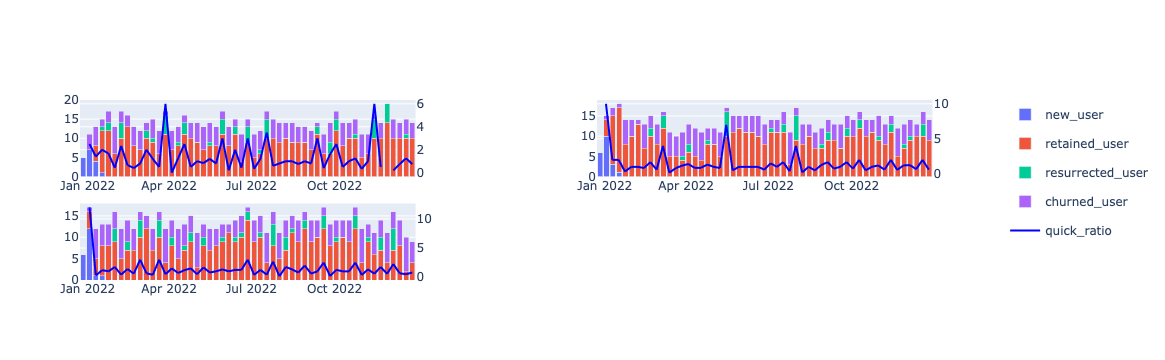

In [147]:
fig_per_group = (
    px.bar(
        new.reset_index(),
        x=COL_TIMESTAMP,
        y=["new_user", "retained_user", "resurrected_user", "churned_user"],
        **facet_col_args,
    )
).update_layout(**commomn_layout)

fig_quick_ratio = (
    px.line(
        new.reset_index(),
        x=COL_TIMESTAMP,
        y=["quick_ratio"],
        markers=False,
        render_mode="webgl",
        **facet_col_args,
    ).update_traces(line_color="blue")
).update_layout(**commomn_layout)


# https://github.com/plotly/plotly.py/issues/2232
import math

num_cols = 2
num_rows = 2
spec_list = [{"secondary_y": True} for x in range(0, num_cols)]
spec_list = [spec_list for y in range(0, num_rows)]
# spec_list = [spec_list , [{"secondary_y": True}, None]]
# print(spec_list)
fig = make_subplots(cols=num_cols, rows=num_rows, specs=spec_list)
# print(fig)

p1 = fig_per_group
p2 = fig_quick_ratio

for i, data in enumerate(p1.data):
    ii = i % 3
    # print(i, data.name, data.xaxis, data.yaxis)
    row = math.ceil((ii + 1) / num_cols)
    col = ii + 1 - (row - 1) * num_cols
    # print(row, col)
    fig.add_trace(data, secondary_y=False, row=row, col=col)

for i, data in enumerate(p2.data):
    # print(i, data.name, data.xaxis, data.yaxis)
    row = math.ceil((i + 1) / num_cols)
    col = i + 1 - (row - 1) * num_cols
    # print(row, col)
    fig.add_trace(data, secondary_y=True, row=row, col=col)

fig.update_layout({"barmode": "stack"})
fig.show()

# Other metrics TBD
* MAU / installation count
* new user / MAU
* DAU / MAU
* Dn / Mn / Wn metrics
* TBD
  * Lness
  * Cohort

In [20]:
def get_new_user_mau(df, freq="W-SUN"):
    return (
        pd.DataFrame(get_new_user(df))
        .reset_index()
        .groupby(pd.Grouper(key="index", freq=freq))
        .sum()
        / pd.DataFrame(get_dau(df))
        .reset_index()
        .groupby(pd.Grouper(key="index", freq=freq))
        .sum()
    )


get_new_user_mau(df).plot.bar()


def get_mau_installation(df, freq="W-SUN"):
    return pd.DataFrame(get_dau(df)).reset_index().groupby(
        pd.Grouper(key="index", freq=freq)
    ).sum().fillna(0) / pd.DataFrame(get_new_user(df)).reset_index().groupby(
        pd.Grouper(key="index", freq=freq)
    ).sum().cumsum().fillna(
        0
    )


get_mau_installation(df).plot()


def get_dn_wn_mn_metrics(
    df, range_=[(1, 0), (7, 1), (28, 7), (84, 28), (84, 28), (364, 84)]
):
    def app(x):
        first = x.idxmax()
        return x.loc[first:].reset_index(drop=True)

    dn = df.T.apply(app, axis=1)
    pairs = {
        f"d{pair[0]}_d{pair[1]}": (
            (dn.loc[:, pair[0]] == 1).sum() / (dn.loc[:, pair[1]] == 1).sum()
        )
        for pair in range_
        if dn.shape[1] > pair[0]
    }

    return pairs


get_dn_wn_mn_metrics(df, [(elem + 1, elem) for elem in range(8)])

TypeError: get_new_user() missing 1 required positional argument: 'add_column'